In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

### cathy 데이터 불러오기

In [2]:
number_of_data = 18
img_height_size = 128
img_width_size = 128
train = np.zeros(number_of_data * img_height_size * img_width_size , dtype=np.int32).reshape(number_of_data,img_height_size,img_width_size)

In [3]:
i = 0
for file in sorted(glob.glob('./cathy/*.jpg')):
    img = Image.open(file)
    img = img.resize((img_width_size,img_height_size))
    train[i] = np.array(img,dtype=np.int32)
    i += 1


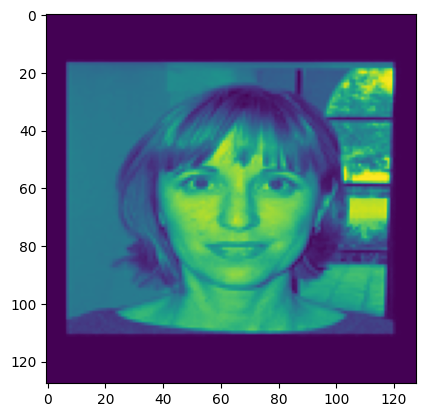

In [4]:
plt.imshow(train[0])

### 3D vector 변환

In [5]:
width , height , channel = 128, 128, 1
x_train = train.reshape(train.shape[0],width, height, channel)

In [6]:
# image pixel normalization [ 0 , 255 ] -> [-1 , 1]
# 왜냐 강화학습에서는 adam 보다는 tanh 를 더 많이 사용한다.
X = (x_train - 127.5) / 127.5

### 이미지 시각화

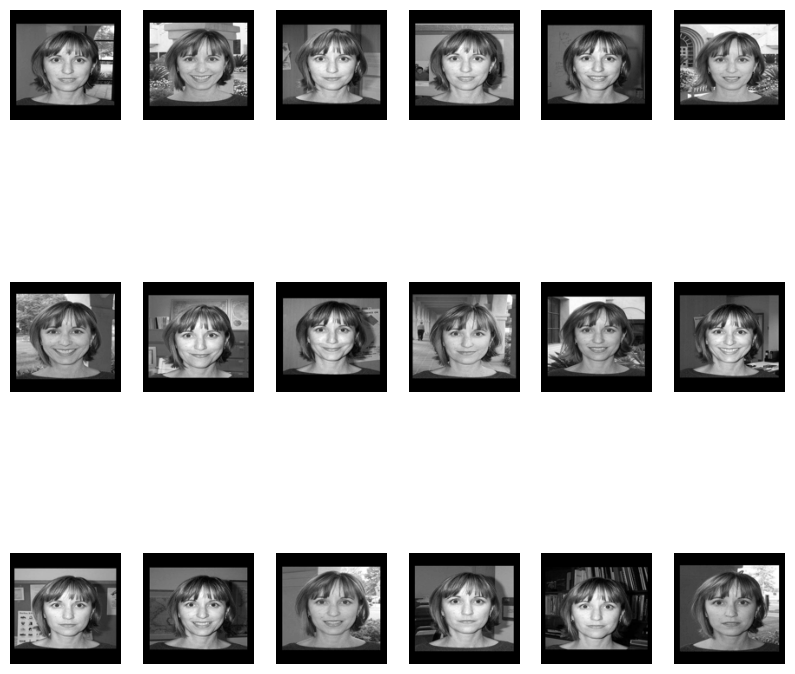

In [7]:
plt.figure(figsize=(10,10))

i = 1
for image in X:
    plt.subplot(3, 6, i)
    image = image.reshape(width , height )
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    i += 1
    if i > 18 : break

plt.show()

### 강화학습으로 새로운 이미지 만들기

In [8]:
import tensorflow as tf

In [9]:
# 학습 데이터 batch 준비
BATCH_SIZE = 10

# BATCH size 나누기
train_dataset = tf.data.Dataset.from_tensor_slices(X).batch(BATCH_SIZE) # 데이터를 batch size 만큼 나눠서 쓴다.
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float64, name=None)>

#### 생성자 모델 (Generator Model)

In [11]:
# Generator 모델 네트워크 구성

def build_generator_model():
    model = keras.Sequential() # Keras 모델 생성

    model.add(keras.layers.Dense(1024, input_dim=18, use_bias=False)) # 100 = 10*10
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    model.add(keras.layers.Dense(32*32*128, use_bias=False)) # 128 / 4 = 32
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    # Resahpe (7*7)
    model.add(keras.layers.Reshape((32, 32, 128)))  # 128 / 4 = 32
    
    model.add(keras.layers.Conv2DTranspose(512, (5, 5), # 128 * 2 * 2
                                    strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization()) 
    model.add(keras.layers.LeakyReLU())
    
    # (7*7) -> (14*14)
    model.add(keras.layers.Conv2DTranspose(256, (5, 5), # 128 * 2
                                    strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    
    # (14*14) -> (28*28)
    model.add(keras.layers.Conv2DTranspose(1, (5, 5), 
                                    strides=(2, 2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

In [12]:
# 생성자 모델 생성
generator = build_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              18432     
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 131072)            134217728 
                                                                 
 batch_normalization_1 (Batc  (None, 131072)           524288    
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 131072)            0

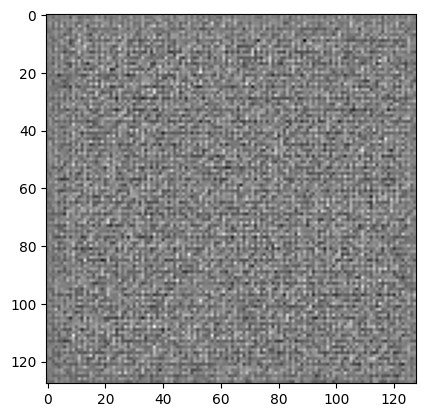

In [13]:
# 학습되지 않은 생성자 모델이 만든 이미지
noise = tf.random.normal([1,18]) # 100 : 출력 이미지 갯수
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0,:,:,0],cmap='gray')

--- 
### 판별자 모델 만들기

In [14]:
# Discriminator 모델 네트워크 구성

def build_discriminator_model():

    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(256, (5, 5), strides=2, padding='same',  # 256 = 128 * 2
                       input_shape=[128, 128, 1])) # input image size
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(512, (5, 5), strides=2, padding='same')) # 112 = 56 * 2
    model.add(keras.layers.LeakyReLU(0.2))
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(1024)) # 224 = 112 * 2
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(1))
    
    return model

In [15]:
# 판별자 모델 만들기
discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 256)       6656      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 256)       0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 512)       3277312   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 512)       0         
                                                                 
 flatten (Flatten)           (None, 524288)            0         
                                                                 
 dense_2 (Dense)             (None, 1024)             

### 학습되지 않은 판별자의 결과 보기

In [16]:
predicted = discriminator(generated_image)
print(predicted)

tf.Tensor([[-5.3564905e-05]], shape=(1, 1), dtype=float32)


---
### Optimizer + Loss Function

In [17]:
# Optimizer 생성
# 생성자용
generator_optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# 판별자용
discriminator_optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [18]:
# Binary Crossentropy for MinMax
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
# Generator Loss 함수
# 생성자 모델의 목표는 : 
# 판별자 모델의 가짜 이미지를 판별했을 때 판별 값이 1에 가까워 지도록 만드는 것이다.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # 1이라고 리턴 하지 않는게 ones_like 함수 이다.

In [20]:
# Discriminator Loss 함수
# 판별자 모델의 목표는 : 
# 1. 진짜 이미지를 판별했을 때 판별값이 1에 가까워 지도록
# 2. 가짜 이미지를 판별했을 때 판별값이 0에 가까워 지도록 만든다.
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 1과 진짜 이미지 판별 값 비교
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 0과 가짜 이미지 판별 값 비교
    total_loss = real_loss + fake_loss
    return total_loss


---
### 강화 학습

In [21]:
# 학습값 설정
EPOCHS = 1000
noise_dim = 18 

In [22]:
# tf.function 에서는 파이썬 코드의 문장 실행 순서를 참조하여 실행 순서의 모호성을 해결합니다. tensorflow에서는 사용하는 것이 좋다.
@tf.function
def train_step(images):
    # 생성자 input noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # Gradient descent 계산 및 파라미터 업데이트
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True) # 진짜 이미지를 봤을 때의 판별 값
      fake_output = discriminator(generated_images, training=True) # 가짜 이미지를 봤을 때의 판별 값

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
# 테스트 노이즈 시각화 함수

test_noise = tf.random.normal([18, noise_dim]) # 학습 시각화를 위한 테스트 노이즈 100개

def show_generated_images(epoch):
    images = generator.predict(test_noise)
    images = 0.5 * images + 0.5 # tanh는 sigmoid보다 데이터 범위가 2배가 더 크므로 이를 조정 
    
    plt.figure(figsize=(11,11))
    
    i = 1
    for image in images:
        image = image.reshape(width, height)
        plt.subplot(3, 6, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        i+=1

    plt.suptitle("Generated Images on EPOCH: %s" % epoch, fontsize = 25)
    plt.show()

In [24]:
# 학습코드
def train(dataset,epochs):
    for epoch in range(epochs):
        for image_batch in dataset: # batch학습 : 64
            train_step(image_batch)
        print('%s epochs trained'%epoch)
        if epoch % 5 == 0:
            show_generated_images(epoch)

2023-03-06 17:51:31.135366: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


0 epochs trained
1/1 [==============================] - 2s 2s/step


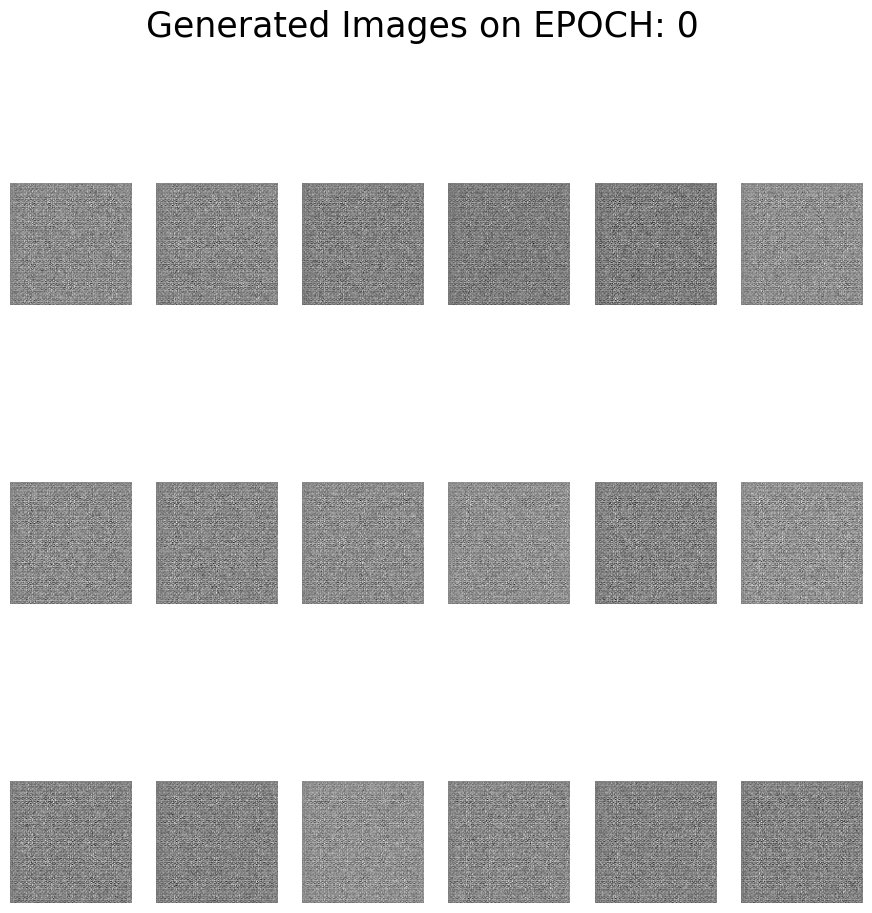

1 epochs trained
2 epochs trained
3 epochs trained


In [25]:
# 학습 시작
train(train_dataset,EPOCHS + 1)